### Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles (DeepMind, NIPS 2017)

-  Compared to Bayesian NNs (e.g. variational inference or MCMC methods), our method is much simpler to implement, requires surprisingly few modifications to standard NNs, 
- Most work on uncertainty in deep learning focuses on Bayesian deep learning; we hope that the simplicity and strong empirical performance of our approach will spark more interest in non-Bayesian approaches for predictive uncertainty estimation.

#### Proper scoring rules

- A scoring rule assigns a numerical score to a predictive distribution $p_\theta(y|x)$, rewarding better calibrated predictions
over worse.
- The expected scoring rule is then $S(p_\theta, q) = \int
q(y, x)S(p_\theta, (y, x))dydx$, where $q(x,y)$ is true (x,y) distribution, $S(\cdot)$ is a scoring function given $(x,y)$.
- Then, we simply minimize $\mathcal{L}(\theta)= -S(p_\theta, q) $

-------------------------

- It turns out many common NN loss functions are proper scoring rules. For example, when *maximizing likelihood*, the score function is $S(p_\theta, (y, x)) = \log p_\theta(y|x)$, and this is a proper scoring rule due
to Gibbs inequality.
- In the case of multi-class K-way classification, the popular softmax cross entropy loss is equivalent to the log likelihood and is a proper scoring rule.
- Interestingly, $\mathcal{L}(\theta)= -S(p_\theta, (y,x)) = \frac{1}{K} \sum_{k=1}^{K} (\text{one-hot label} - \text{softmax})^2$ , i.e., minimizing the squared error between the predictive probability of a label and one-hot encoding of the correct label, is also a proper scoring rule known as the **Brier score**.

#### Adversarial training
- Interestingly, adversarial training can be interpreted as a computationally efficient solution to smooth the predictive distributions by increasing the likelihood of the target around an $\epsilon$-neighborhood of
the observed training examples.

####  Ensembles
-  One of the popular strategies is bagging (a.k.a. bootstrapping), where ensemble members are trained on different
bootstrap samples of the original training set.
- Note: The bootstrap draws N times uniformly with replacement from a dataset with N items. The probability an item is picked at least once is $1 − (1 − 1/N)^N$, which for large N becomes $1 − e^{−1} \approx 0.632$. Hence, the
number of unique data points in a bootstrap sample is 0.632 ×N on average.
    - However, with NNs, the bootstrap can sometimes hurt performance since a base learner trained
on a bootstrap sample sees only 63% unique data points. Thus, the authors used the entire training dataset to train each network since deep NNs typically perform better with more data. They found that random initialization of the NN parameters, along with random shuffling of the data points, was
sufficient to do ensemble learning.

#### Network architecture
- we use a network that outputs two values in the final layer, corresponding to the predicted mean $\mu(x)$ and variance
$\sigma^2(x) > 0$. By treating the observed value as a sample from a Gaussian distribution. 

#### Different types of uncertainties
- Training a single probabilistic NN $p_\theta(y|x)$ using proper scoring rules as training objectives captures ambiguity (**inherent noise**) in targets y for a given x. In addition, our method uses a combination of ensembles (which captures **“model uncertainty”** by averaging predictions over multiple models
consistent with the training data), and adversarial training (which encourages local smoothness),
- They quantify aleatoric uncertainty with the network output, $\sigma^2$, and estimate epistemic uncertainty with ensemble methods.
    - for exampele, if inherently confusing '4' is sometimes labelled as '4' and somtimes as '9' in the same training set. Then this density network try to increase $\sigma^2$. 
    - The prices of the stocks that had the same pattern in the past at A and B, afterwards the price went up for the former and went down for the latter. Then the network average two prices to output $\mu(x)$, and increase $\sigma^2$ to include both points. This represents measurement noise, inherent noise. 

#### Training criterion for regression
- With Gaussuan assumption, $N(\mu(x), \sigma^2(x))$, the negative log-likelihood (NLL) is defined as:

<img src=attachment:image.png width=300>
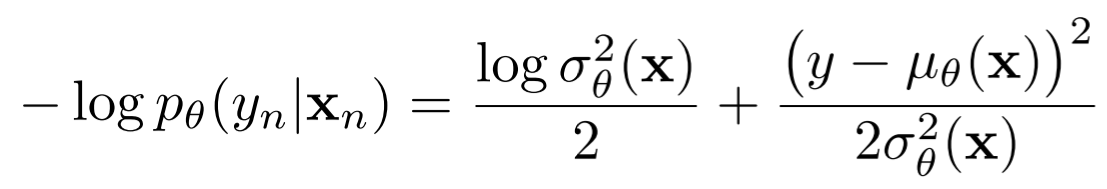

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("white")
test_ratio = 0.1
data_step = 0.005
data_sigma1 = 2
data_sigma2 = 1
def func(x):
    return np.power(x, 3)

num_data= 1201

data_x = np.linspace(-3, 3, num_data)
data_y = np.zeros(num_data)
data_y_true = np.zeros(num_data)

In [3]:
for i in range(num_data):
    if (data_x[i] < 0):  # -3 <= x <0, sigma=2 (has more uncertainty inherently)
        data_y[i] = func(data_x[i]) + np.random.normal(0, data_sigma1)
    else:  # x>0, sigma=1 (less noisy measurement)
        data_y[i] = func(data_x[i]) + np.random.normal(0, data_sigma2)
        
    data_y_true[i] = func(data_x[i])

In [4]:
num_train_data = int(num_data * (1 - test_ratio))
num_test_data  = num_data - num_train_data

data_x = np.reshape(data_x, [num_data, 1])
data_y = np.reshape(data_y, [num_data, 1])
data_y_true = np.reshape(data_y_true, [num_data, 1])

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

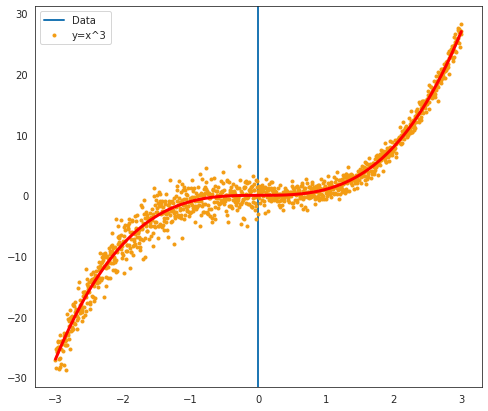

In [5]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x, data_y, '.', markersize=6, color='#F39C12')
plt.plot(data_x, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Layer, Dropout
from keras.models import Model
from keras.initializers import glorot_normal

Using TensorFlow backend.


In [7]:
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.log(sigma) + 0.5*tf.div(tf.square(y_true - y_pred), sigma)) + 1e-6
    return gaussian_loss

In [8]:
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.w_1 = self.add_weight(name='kernel_1', 
                                      shape=(30, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.w_2 = self.add_weight(name='kernel_2', 
                                      shape=(30, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.b_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.b_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.w_1) + self.b_1   # output mu
        output_sig = K.dot(x, self.w_2) + self.b_2   # output sigma
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  # always being positive
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [9]:
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

In [16]:
inputs = Input(shape=(1,))
x = Dense(10, activation='relu')(inputs)
x = Dense(6, activation='relu')(x)
x = Dense(30, activation='relu')(x)
mu, sigma = GaussianLayer(output_dim=1, name='main_output')(x)
model = Model(inputs, mu)
model.compile(loss=custom_loss(sigma), optimizer='adam')
model.fit(train_x, train_y, epochs=300, verbose=1)

Epoch 1/300
1080/1080 [==============================] - 1s 498us/step - loss: 18.9954
Epoch 2/300
1080/1080 [==============================] - 0s 69us/step - loss: 16.8864
Epoch 3/300
1080/1080 [==============================] - 0s 77us/step - loss: 14.4001
Epoch 4/300
1080/1080 [==============================] - 0s 75us/step - loss: 11.3514
Epoch 5/300
1080/1080 [==============================] - 0s 78us/step - loss: 8.5032
Epoch 6/300
1080/1080 [==============================] - 0s 79us/step - loss: 6.3467
Epoch 7/300
1080/1080 [==============================] - 0s 79us/step - loss: 4.8480
Epoch 8/300
1080/1080 [==============================] - 0s 78us/step - loss: 3.8229
Epoch 9/300
1080/1080 [==============================] - 0s 77us/step - loss: 3.1143
Epoch 10/300
1080/1080 [==============================] - 0s 76us/step - loss: 2.6671
Epoch 11/300
1080/1080 [==============================] - 0s 74us/step - loss: 2.3872
Epoch 12/300
1080/1080 [==============================] - 

1080/1080 [==============================] - 0s 74us/step - loss: 0.9140
Epoch 97/300
1080/1080 [==============================] - 0s 75us/step - loss: 0.9128
Epoch 98/300
1080/1080 [==============================] - 0s 75us/step - loss: 0.9076
Epoch 99/300
1080/1080 [==============================] - 0s 76us/step - loss: 0.9041
Epoch 100/300
1080/1080 [==============================] - 0s 75us/step - loss: 0.9045
Epoch 101/300
1080/1080 [==============================] - 0s 74us/step - loss: 0.8998
Epoch 102/300
1080/1080 [==============================] - 0s 76us/step - loss: 0.9071
Epoch 103/300
1080/1080 [==============================] - 0s 74us/step - loss: 0.9067
Epoch 104/300
1080/1080 [==============================] - 0s 74us/step - loss: 0.9016
Epoch 105/300
1080/1080 [==============================] - 0s 76us/step - loss: 0.8974
Epoch 106/300
1080/1080 [==============================] - 0s 75us/step - loss: 0.8984
Epoch 107/300
1080/1080 [==============================] - 0

1080/1080 [==============================] - 0s 74us/step - loss: 0.8578
Epoch 191/300
1080/1080 [==============================] - 0s 74us/step - loss: 0.8513
Epoch 192/300
1080/1080 [==============================] - 0s 74us/step - loss: 0.8630
Epoch 193/300
1080/1080 [==============================] - 0s 73us/step - loss: 0.8561
Epoch 194/300
1080/1080 [==============================] - 0s 75us/step - loss: 0.8530
Epoch 195/300
1080/1080 [==============================] - 0s 76us/step - loss: 0.8591
Epoch 196/300
1080/1080 [==============================] - 0s 76us/step - loss: 0.8628
Epoch 197/300
1080/1080 [==============================] - 0s 76us/step - loss: 0.8529
Epoch 198/300
1080/1080 [==============================] - 0s 73us/step - loss: 0.8612
Epoch 199/300
1080/1080 [==============================] - 0s 73us/step - loss: 0.8617
Epoch 200/300
1080/1080 [==============================] - 0s 73us/step - loss: 0.8605
Epoch 201/300
1080/1080 [==============================] 

1080/1080 [==============================] - 0s 77us/step - loss: 0.8539
Epoch 285/300
1080/1080 [==============================] - 0s 77us/step - loss: 0.8495
Epoch 286/300
1080/1080 [==============================] - 0s 73us/step - loss: 0.8510
Epoch 287/300
1080/1080 [==============================] - 0s 76us/step - loss: 0.8489
Epoch 288/300
1080/1080 [==============================] - 0s 76us/step - loss: 0.8548
Epoch 289/300
1080/1080 [==============================] - 0s 77us/step - loss: 0.8604
Epoch 290/300
1080/1080 [==============================] - 0s 75us/step - loss: 0.8512
Epoch 291/300
1080/1080 [==============================] - 0s 76us/step - loss: 0.8493
Epoch 292/300
1080/1080 [==============================] - 0s 75us/step - loss: 0.8496
Epoch 293/300
1080/1080 [==============================] - 0s 73us/step - loss: 0.8514
Epoch 294/300
1080/1080 [==============================] - 0s 73us/step - loss: 0.8541
Epoch 295/300
1080/1080 [==============================] 

In [17]:
# Define a new function named 'get_intermediate'

layer_name = 'main_output' # Where to extract the Gaussian output from. 
get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

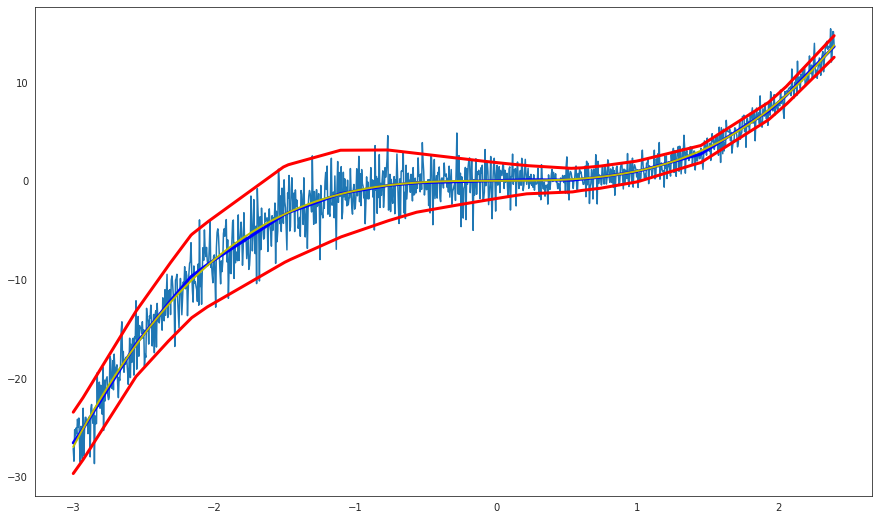

In [18]:
preds, sigmas = [], []
for j in range(len(train_x)):
    mu, sigma = get_intermediate([[train_x[j]]])
    preds.append(mu.reshape(1,)[0])
    sigmas.append(sigma.reshape(1,)[0])
plt.figure(1, figsize=(15, 9))
plt.plot([i[0] for i in train_x], [i for i in train_y])
plt.plot([i[0] for i in train_x], [i for i in preds], 'b', linewidth=3)
upper = [i+k for i,k in zip(preds, sigmas)]
lower = [i-k for i,k in zip(preds, sigmas)]
plt.plot([i[0] for i in train_x], [i for i in upper], 'r', linewidth = 3)
plt.plot([i[0] for i in train_x], [i for i in lower], 'r', linewidth = 3)
plt.plot([i[0] for i in train_x], [func(i[0]) for i in train_x], 'y', linewidth = 2)
plt.show()

#### Single network uncertainty estimation

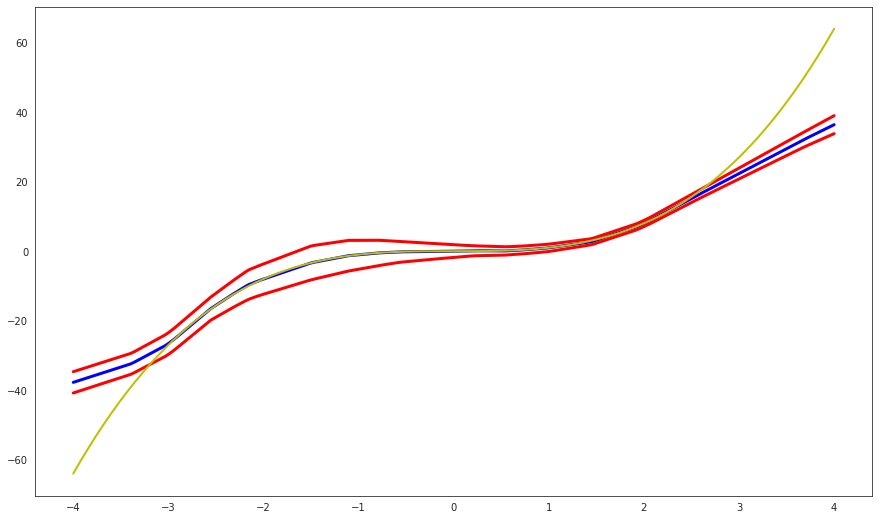

In [20]:
x_ax = np.linspace(-4, 4, num=200)
preds, sigmas = [], []
for j in range(len(x_ax)):
    
    mu, sigma = get_intermediate([[np.array([x_ax[j]])]])
    preds.append(mu.reshape(1,)[0])
    sigmas.append(sigma.reshape(1,)[0])
plt.figure(1, figsize=(15, 9))
plt.plot([i for i in x_ax], [i for i in preds], 'b', linewidth=3)
upper = [i+k for i,k in zip(preds, sigmas)]
lower = [i-k for i,k in zip(preds, sigmas)]
plt.plot([i for i in x_ax], [i for i in upper], 'r', linewidth = 3)
plt.plot([i for i in x_ax], [i for i in lower], 'r', linewidth = 3)
plt.plot([i for i in x_ax], [func(i) for i in x_ax], 'y', linewidth = 2)
plt.show()

#### Ensembling
- Ensemble results are then treated as a uniformly-weighted mixture model, although *for simplicity the ensemble prediction is approximated to be a Gaussian whose mean and variance are respectively the mean and variance of the mixture*.

<img src=attachment:image.png width=750>
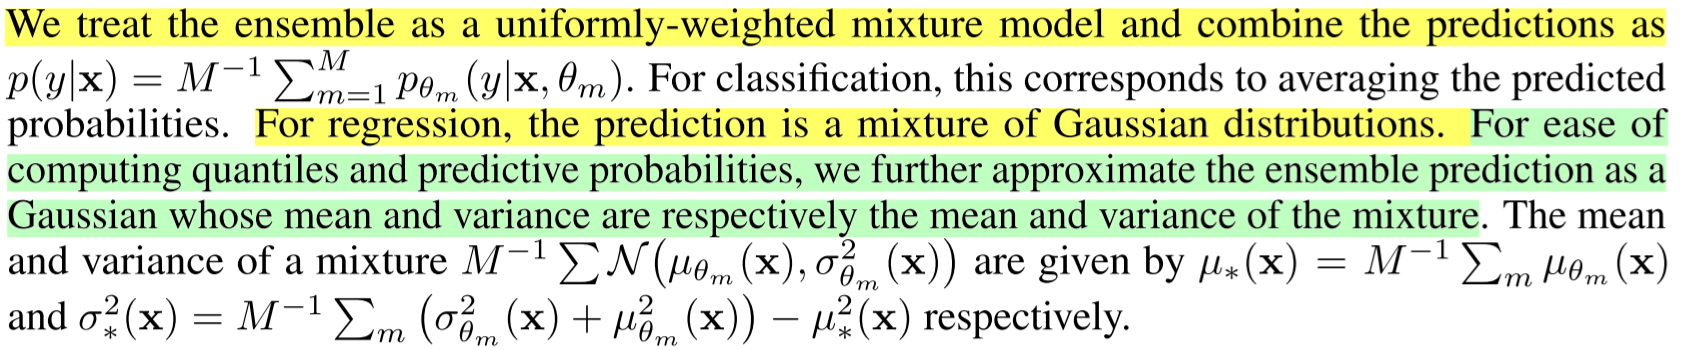

In [21]:
# Train NNs ensemble
def create_trained_network(train_x, train_y):
    inputs = Input(shape=(1,))
    x = Dense(10, activation='relu')(inputs)
    x = Dense(6, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    mu, sigma = GaussianLayer(1, name='main_output')(x)
    model = Model(inputs, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(train_x, train_y, epochs=300, verbose=0)
    layer_name = 'main_output' # Where to extract the output from
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

    return get_intermediate

prediction_fns = []
for i in range(10):
    prediction_fns.append(create_trained_network(train_x, train_y))
    print('Model No.{} trained.'.format(i+1))

Model No.1 trained.
Model No.2 trained.
Model No.3 trained.
Model No.4 trained.
Model No.5 trained.
Model No.6 trained.
Model No.7 trained.
Model No.8 trained.
Model No.9 trained.
Model No.10 trained.


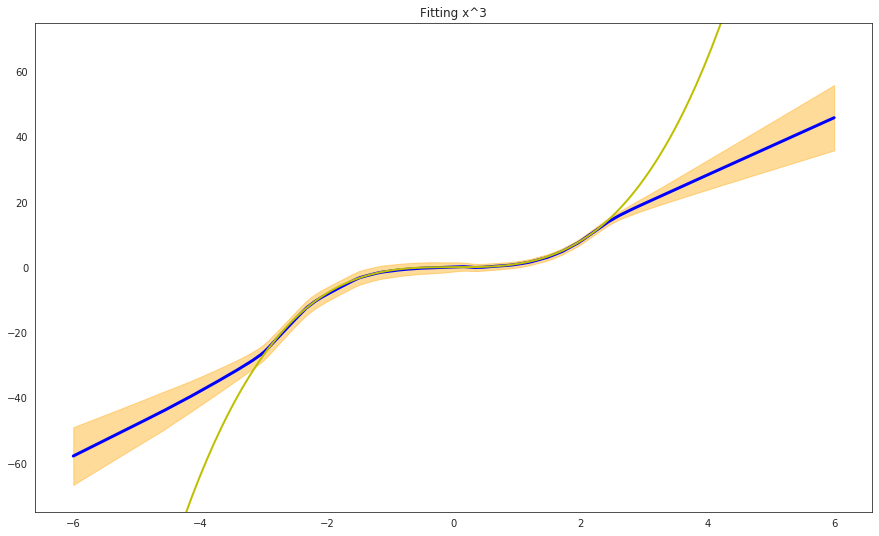

In [24]:
# Plot test with multiple networks
x_ax = np.linspace(-6, 6, num=200)
preds, sigmas = [], []
for j in range(len(x_ax)):
    
    mu_sigma = [(prediction_fns[i]([[np.array([x_ax[j]])]])[0][0][0], \
                prediction_fns[i]([[np.array([x_ax[j]])]])[1][0][0]) \
                for i in range(len(prediction_fns))]
    out_mus = [i for i,j in mu_sigma]
    out_mu = np.mean(out_mus)
    out_sigmas = [j for i,j in mu_sigma]
    out_sigma = np.sqrt(np.mean(out_sigmas + np.square(out_mus)) - np.square(out_mu))
    preds.append(out_mu.reshape(1,)[0])
    sigmas.append(out_sigma.reshape(1,)[0])
plt.figure(1, figsize=(15, 9))
plt.plot([i for i in x_ax], [i for i in preds], 'b', linewidth=3)
upper = [i+k for i,k in zip(preds, sigmas)]
lower = [i-k for i,k in zip(preds, sigmas)]
plt.fill_between(x_ax, upper, lower, color="orange", alpha=0.4)
plt.plot([i for i in x_ax], [func(i) for i in x_ax], 'y', linewidth = 2)
plt.ylim(-75, 75)
plt.show()